# Starting out

## Verifying Ryan's provided code

I started by running Ryan's code "out of the box" to confirm the calculated steady state k_eff is the same he calculates. I wasn't able to match to the paper, but when we met with him in February he said just running the code as-downloaded with the following parameters <br> 
- Inner thickness (between two fuel areas) = 20  
- Total length of slab = 25.25  
- Reflector thickness = 3  
- Number of zones, I = 400 for above k values  
- Quadrature, N = 4  
    
he got k = 0.99637. This gave me k = 0.97996. My best guess is that we're using different python versions and there's some variation in the mathematic accuracy between the two.

### Basic outline of steady-state code:

`
A. For every energy group
        1. Calculate fission and scattering operators
        2. For every angle
                a. For every zone
                        - Calculate angular flux in this zone, at this angle and energy, using diamond difference
        3. Sum angular flux in each zone using le gendre weighting to get scalar flux
        4. Check convergence of scalar flux in this energy group, iterate
B. Check convergence of scalar flux over all energy groups, iterate
C. Calculate k_eff
D. Check convergence of k_eff, iterate`

Check flux convergence using
$$ \frac{||\phi - \phi_{old}||_2}{||\phi||_2} < \text{1.0e-8} $$
And $k_{eff}$ convergence using
$$ \frac{(k - k_{old})}{k} < \text{1.0e-8} $$

### Time-eigenvalue code:
Performs A and B at every time step and returns a matrix $\phi$ with dimensions (I x G x steps) and $\Psi$ with dimensions (I x N x G x steps). The $\Psi$ matrix is used to compute alpha eigenvalues doing the following:

1. Reshape psi into a matrix of size (I * G * N, steps) so each column contains the angular flux info at that step (chunked by zone, then further by direction, then kept in group order. Ordered by energy inside direction inside zone. I think.)
2. Compute an SVD on all but the last column of \Psi (this is $\Psi_{-}$ from the paper) to get u, s, and v 
3. The spos cutoff - cumsum is used, where every element is equal to the sum of all previous elements

$$ 1 - \frac{cumsum(s)}{sum(s)} > 1e-13 $$

4. The diagonal of S is 1/spos, and columns of u and rows of v are truncated so they're the same size as S
5.  $\tilde{A} = u^H \cdot \Psi \cdot v^H \cdot S $
6. Calculate eigenvalues of $\tilde{A}$
7. $\alpha = \left(1 - \frac{1}{\text{eigs}} \right)\text{dt} $

## Noted (seemingly unrelated) issue with solving the alpha-eigenvalue problem
The final step of the code as-downloaded is to solve the alpha eigenvalue problem using the calculated alphas. Some noted issues:
 - The code calls a function multigroup_alpha to solve the eigenvalue problem. As downloaded, the call is missing the minimum alpha parameter; it's called using only `np.max(np.real(eigs))`.
 - According to Ryan's paper and a cited Lathouwers paper, the calculation should be performed using alpha eigenvalues with maximum and minimum magnitude values, so I added in the parameter `np.min(np.abs(np.real(eigs)))` to the function call.
 - The first step of the function multigroup_alpha is to calculate scattering cross sections based on the input alpha eigenvalues, then use those scattering cross sections to perform a steady-state k-eigenvalue solve. It checks that the k using the minimum alpha is less than one, and the k using the maximum alpha is greater than one, then begins attempting to converge on a final alpha-eigenvalue.
 - Running Ryan's code out of the box fails these checks. For the maximum alpha k = 0.24, and for the minimum k = 0.66

# Comparing Ryan's code to an infinite homogeneous medium using linear algebra
We also met in February and went over how one would solve the transport equation using linear algebra assuming a homogeneous infinite medium, so I coded that up. After we discovered Ryan's code did not in fact have reflecting boundary conditions to imitate an infinite medium, I instead just increased the size of the slab as large as I could and still have it converge, at his recommendation. The k's are pretty close considering his isn't actually infinite.
$$ k_{eff,kayla} = 2.959$$ $$k_{eff,ryan} = 2.955$$

## The math
Transport problem:
$$ \Omega \cdot \nabla \Psi_g + \Sigma_{t,g}\Psi_g = \frac{1}{4\pi} \sum_{g=1}^G \Sigma_{s,g,g'}\phi_g + \frac{\chi_g}{4\pi} \sum_{g'=1}^G \nu \Sigma_{f,g'}\phi_{g'}\frac{1}{k}$$

Assume infinite medium:
$$ \Sigma_{t,g}\phi_g = \sum_{g=1}^G \Sigma_{s,g,g'}\phi_g + \chi_g \sum_{g'=1}^G \nu \Sigma_{f,g'}\phi_{g'}\frac{1}{k}$$

Normalize:
$$ \sum_{g'=1}^G \nu \Sigma_{f,g'}\phi_{g'}\frac{1}{k} = 1$$

to get
$$ \Sigma_{t,g}\phi_g = \sum_{g=1}^G \Sigma_{s,g,g'}\phi_g + \chi_g $$

Calculate group fluxes using:
$$ \underline{\phi}_g = \{ \underline{\Sigma}_{t,g} - \underline{\Sigma}_{s,g} \} ^{-1} \underline{\chi}_g $$

And plug back into the above normalization to solve for k.

In [1]:
def matrix_solve(sigma_s, sig_t_in, chi, nusigma_f, G):
    """Compute homogeneous k_inf and flux for given energy data
    Data from Ryan McClarren
    Inputs:
        G:               number of groups 
    Outputs:
        phi:             value of scalar flux in each group
    """
    sigma_t = np.zeros((G,G))
    phi = np.zeros(G)
    
    for i in range(G):
        sigma_t[i,i] = sig_t_in[i]
    
    Diff = sigma_t - sigma_s
    iDiff = np.linalg.inv(Diff)
    phi = np.matmul(iDiff,chi)

    k = 0
    for i in range(G):
        k += nusigma_f[i]*phi[i]

# Group collapse
The code uses 70 group data for Pu and poly, and that combined with the large number of zones needed for accuracy, and then the 100 time steps needed for the DMD, resulted in some long-running calculations. I collapsed from 70 groups to 12 because Ryan had provided 12-group Pu data, so I had something to compare that to and edges to start with. Infinite homogeneous flux with metal data: <br> <br> $$k_{\infty,70} = 2.95913$$ $$k_{\infty,12} = 2.95911$$

## Method
1. Fine group input data: inverse speed, chi, nu * sigma_f, sigma_s, sigma_t, group edges
2. Use above to calculate fine group infinite flux
3. Coarse group input: group edges
4. Compare coarse to fine group edges to determine which fine group indices go into which coarse groups
5. Collapse phi and chi by summing fine groups into proper coarse groups
6. Collapse parameters (P) inverse speed, nu * sigma_f, and sigma_t using:
$$ \text{P}_{coarse} \phi_{coarse} = \sum \text{P}_{fine} \phi_{fine} $$ 
7. Collapse fine $\Sigma_{s,g',g}$ into $\Sigma_{s,k',k}$ by summing scattering from all fine groups in k' to all fine groups in k. In the code, sigma_s[i,j] is scattering from j to i, which in nuclear notation is $\Sigma_{s,j,i}$. So good thing I never confused myself with that and erased all of my code only to realize I had it right in the first place. :)
$$ \sum_{g' \epsilon k'} \left( \sum_{g \epsilon k} \Sigma_{s,g',g}\phi_{g'} \right) = \Sigma_{s,k',k}\phi_{k'} $$

In [ ]:
def collapse(phi, n, fine_edges, coarse_edges, G, chi, sigma_t, sigma_s, nusigma_f, inv_speed, opt):
    """Perform group collapse
    Data from Ryan McClarren
    Inputs:
        phi:             fine group infinite homogeneous flux 
        n:               coarse group size
        fine_edges:      fine group edges
        coarse_edges:    coarse group edges
        G:               fine group size
        opt:             whether to calculate inv_speed; only metal inv_speed is used
    Outputs:
        psi:             value of angular flux in each zone
    """
    coarse_phi = np.zeros(n)
    coarse_scat = np.zeros((n,n))
    coarse_sigt = np.zeros(n)
    coarse_chi = np.zeros(n)
    coarse_nusigf = np.zeros(n)
    coarse_invspeed = np.zeros(n)
    

    # Get corresponding fine group number for coarse group edges
    index = np.zeros(n+1,np.int)
    i = 0
    for j in range(G):
        if i > n:
            break
        if ( abs(fine_edges[j] - coarse_edges[i]) < 0.0001 ):
            index[i] = j
            i += 1
    
    # Calculate coarse group flux, chi, sigt, nusigf, and invspeed
    i = 1
    for j in range(index[n]):
        if j < index[i]:                    # If we're in the current coarse group
            coarse_phi[i-1] += phi[j]
            coarse_chi[i-1] += chi[j]
            
            # These will be divided by group flux once calculated
            coarse_sigt[i-1] += sigma_t[j]*phi[j]
            coarse_nusigf[i-1] += nusigma_f[j]*phi[j]
            coarse_invspeed[i-1] += inv_speed[j]*phi[j]
            
            
            if (j == index[i] - 1):         # If the next fine group is in the next coarse group, divide by coarse flux and move to next coarse group
                coarse_sigt[i-1] = coarse_sigt[i-1]/coarse_phi[i-1]
                coarse_nusigf[i-1] = coarse_nusigf[i-1]/coarse_phi[i-1]
                coarse_invspeed[i-1] = coarse_invspeed[i-1]/coarse_phi[i-1]
                i += 1

    # Calculate coarse scattering cross sections  
    # Sum scattering from all groups in coarse_from to all groups in coarse_to
    for coarse_from in range(n):
        fromgroups = (index[coarse_from], index[coarse_from + 1])
        coarseflux = coarse_phi[coarse_from]
        for coarse_to in range(n):
            togroups = (index[coarse_to], index[coarse_to + 1])
            
            for fine_from in range(fromgroups[0], fromgroups[1]):
                fineflux = phi[fine_from]
                for fine_to in range(togroups[0], togroups[1]):
                    coarse_scat[coarse_to, coarse_from] += sigma_s[fine_to, fine_from]*fineflux
                    
            coarse_scat[coarse_to, coarse_from] = coarse_scat[coarse_to, coarse_from]/coarseflux
            

# Alpha Eigenvalues (The thing we actually cared about the whole time)
Ran Ryan's time dependent code using the following parameters and the 12 group data. It was indeed faster.

- Inner thickness (between two fuel areas) = 20  
- Total length of slab = 25.25  
- Reflector thickness = 3  
- Number of zones, I = 200
- Quadrature, N = 4  

The time-dependent transport function returns scalar and angular flux. The alpha calculation uses angular flux using the steps we went through. Changing to scalar flux wasn't too big of a change:
1. Reshape phi, instead of psi, into a matrix of size (I*G, steps) so each column contains the angular flux info at that step (chunked by zone, then kept in group order. ordered by energy inside zone. I think.)
2. Compute an SVD on all but the last column the matrix to get u, s, and v (this is $\Psi_{-}$ from the paper)
3. The spos cutoff - cumsum is used, where every element is equal to the sum of all previous elements
4. S is the diagonal of 1/spos
5. A_tilde = unew_transpose * phi * vnew_transpose * S
6. Calculate eigenvalues of A_tilde
7. alphas = (1 - 1/eigs) * dt

100 time steps were used. With the angular flux, 49 of the values in s beat the spos cutoff; with the scalar, 47 did.  
Angular maximum: 5.39  
Scalar maximum: 5.53

## Results of various runs
### Standard
What is the standard run? Running PolyPu-70g as downloaded, but with I = 400. This means L = 25.25, inner_thick = 20, ref_thick = 3, N = 4 (referred to as 'standard' from now on). I somehow saved k wrong, but I believe it was around 0.96


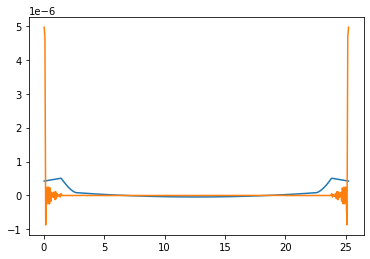

From angular flux, max alpha =  6.504748705267375
From scalar flux, max alpha =  6.6081944898518135
That's a  1.5903117748525843 % difference


In [21]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

standard = np.load('standard.npz')
phi = standard['phi']
seigs = standard['scalar_eigs']
eigs = standard['eigs']

nsteps=100
I = 400
G = 70
L = 25.25
hx = L/I
x = np.linspace(hx/2,I*hx-hx/2,I)

plt.plot(x,phi[:,0,-1])       #blue
plt.plot(x,phi[:,G-1,-1])     #orange
plt.show()

alpha = np.max(np.real(eigs))
s_alpha = np.max(np.real(seigs))
print("From angular flux, max alpha = ",alpha)
print("From scalar flux, max alpha = ", s_alpha)
print("That's a ", 100*(np.abs(alpha-s_alpha)/alpha),"% difference")

In [32]:
#Perturbing scalar flux
#phi is in form [i,g,time]
tol = 1
pert = np.random.uniform(-1,1,(I,G,nsteps))*tol
pert_phi = phi + pert

def compute_alpha(psi_input,skip,nsteps,I,G,N,dt,type):
    #Type 1 is angular, type 2 is scalar
    it = nsteps-1
    
    if type == 1:
        shape = I*G*N
    else:
        shape = I*G
        
    #need to reshape matrix    
    phi_mat = np.zeros((shape,nsteps))
    for i in range(nsteps):
        if type == 1:
            phi_mat[:,i] = np.reshape(psi_input[:,:,:,i],shape)
        else: 
            phi_mat[:,i] = np.reshape(psi_input[:,:,i],shape)
    [u,s,v] = np.linalg.svd(phi_mat[:,skip:it],full_matrices=False)
    print(u.shape,s.shape,v.shape)

    #make diagonal matrix
    #print("Cumulative e-val sum:", (1-np.cumsum(s)/np.sum(s)).tolist())
    spos = s[(1-np.cumsum(s)/np.sum(s)) > 1e-13] #[ np.abs(s) > 1.e-5]
    mat_size = np.min([shape,len(spos)])
    S = np.zeros((mat_size,mat_size))

    unew = 1.0*u[:,0:mat_size]
    vnew = 1.0*v[0:mat_size,:]

    S[np.diag_indices(mat_size)] = 1.0/spos
    Atilde = np.dot(np.dot(np.dot(np.matrix(unew).getH(),phi_mat[:,(skip+1):(it+1)]),np.matrix(vnew).getH()),S)
    print("Atilde size =", Atilde.shape)
    #xnew = np.dot(Atilde,phi_mat[:,0:it])
    #print("Xnew********",xnew[:,1],"phi_mat********",phi_mat[:,1])
    [eigsN,vsN] = np.linalg.eig(Atilde)
    eigsN = (1-1.0/eigsN)/dt
    return eigsN, vsN,u

pert_eigs,pert_vs,pert_u = compute_alpha(pert_phi,2,nsteps,I,G,4,.5,2)
print("max scalar alpha with perturbation = ", np.max(np.real(pert_eigs)))

(28000, 97) (97,) (97, 97)
Atilde size = (96, 96)
max scalar alpha with perturbation =  6.326073168352605


### Collapsed, I = 200
Next was with 12 groups, collapsed using infinite homogeneous flux (I think this must be the problem, it just gives not great results). Same geometry, but I = 200

k = 0.66048  
From angular flux, max alpha = 4.394962074933236  
From scalar flux, max alpha = 5.661063472863963  
That's a large difference.

### Collapsed, I = 400
Next was with 12 groups, collapsed using infinite homogeneous flux, same geometry, I = 400. 

k = 0.6329606728181804
From angular flux, max alpha = -0.06949799105966692
From scalar flux, max alpha = 56.53064386868386
Straight up something must be wrong that I'm not realizing in my sleep deprived state lmao there is No Way that is correct, I've gotten way better numbers before, seriously what is going on what did I somehow change???